# Moneyball: Linear Regression Analysis
## Baseball Analytics and the Power of Data Science

This notebook demonstrates linear regression analysis using baseball data, inspired by the famous Moneyball story. We'll analyze how statistical metrics can predict team performance and identify undervalued players.

**Data Source**: Based on MIT's Analytics Edge course, adapted for Python with enhanced analysis.

## Analysis Framework: ISBE
- **I** - **Inspect**: Explore and understand the data
- **S** - **Select**: Choose relevant features and variables  
- **B** - **Build**: Create and train regression models
- **E** - **Evaluate**: Assess model performance and interpret results 

In [1]:
# =============================================================================
# IMPORT LIBRARIES
# =============================================================================

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Statistical modeling and analysis
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

# Set plotting style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# =============================================================================
# DATA LOADING AND PREPROCESSING
# =============================================================================

def load_baseball_data(from_year=2002):
    """
    Load and preprocess baseball team statistics data.
    
    Parameters:
    -----------
    from_year : int, default=2002
        Filter data to only include years before this year.
        The Moneyball revolution began in 2002, so we focus on historical data.
    
    Returns:
    --------
    pandas.DataFrame
        Cleaned baseball team statistics with derived features
    """
    # Load the raw baseball data
    df = pd.read_csv('data/baseball.csv')
    
    # Filter data to pre-Moneyball era for authentic analysis
    # This simulates the conditions before advanced analytics became mainstream
    if from_year:
        year_filter = df['Year'] < from_year 
        df = df[year_filter]
        df = df.reset_index(drop=True)
    
    # Create derived features for analysis
    # Runs Difference: Key metric for team performance
    df['runs_diff'] = df['RS'] - df['RA']  # Runs Scored - Runs Allowed
    df['RD'] = df['RS'] - df['RA']         # Alternative naming for clarity
    
    print(f"Loaded data for {len(df)} team-seasons from {df['Year'].min()}-{df['Year'].max()}")
    return df

# Load the dataset
df = load_baseball_data()
print("\nFirst 5 rows of the dataset:")
df.head()

Loaded data for 902 team-seasons from 1962-2001

First 5 rows of the dataset:


,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,runs_diff,RD
0,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39,-39
1,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141,141
2,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86,86
3,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142,-142
4,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27,27


## Data Dictionary

Understanding the key metrics used in baseball analytics:

| **Column**       | **Description**                                          | **Importance** |
| ---------------- | -------------------------------------------------------- | -------------- |
| **Team**         | Name of the team                                         | Identifier     |
| **League**        | League (AL/NL)                                          | Categorical    |
| **Year**         | Season year                                              | Temporal       |
| **RS**           | Runs Scored by the team                                  | **Key Target** |
| **RA**           | Runs Allowed by the team                                 | **Key Target** |
| **W**            | Number of wins                                           | **Key Target** |
| **OBP**          | On-Base Percentage (hits + walks + HBP) / plate appearances | **Moneyball Metric** |
| **SLG**          | Slugging Percentage (total bases / at-bats)             | **Moneyball Metric** |
| **BA**           | Batting Average (hits / at-bats)                        | Traditional    |
| **Playoffs**     | Playoff qualification (1 = Yes, 0 = No)                 | **Target**     |
| **G**            | Games played                                             | Context        |
| **OOBP**         | Opponent On-Base Percentage                             | **Defensive**  |
| **OSLG**         | Opponent Slugging Percentage                            | **Defensive**  |
| **runs_diff**    | Run differential (RS - RA)                              | **Derived**    |

### Key Moneyball Insights:
- **OBP** and **SLG** are more predictive of runs than traditional **BA**
- **Run differential** is highly correlated with wins
- **Opponent statistics** (OOBP, OSLG) predict runs allowed


In [3]:
# =============================================================================
# DATA EXPLORATION AND QUALITY ASSESSMENT
# =============================================================================

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)

print(missing_summary[missing_summary['Missing Count'] > 0])

print("\n" + "="*80)
print("DATA QUALITY CHECKS")
print("="*80)
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Unique teams: {df['Team'].nunique()}")
print(f"Year range: {df['Year'].min()} - {df['Year'].max()}")
print(f"League distribution: {df['League'].value_counts().to_dict()}")


DATASET OVERVIEW
Dataset shape: 902 rows × 17 columns
Memory usage: 0.19 MB

MISSING VALUES ANALYSIS
              Missing Count  Missing Percentage
OSLG                    812           90.022173
OOBP                    812           90.022173
RankPlayoffs            748           82.926829
RankSeason              748           82.926829

DATA QUALITY CHECKS
Duplicate rows: 0
Unique teams: 36
Year range: 1962 - 2001
League distribution: {'AL': 462, 'NL': 440}


# =============================================================================
# REGRESSION ANALYSIS: PREDICTING RUNS SCORED
# =============================================================================

## Objective: Build a Linear Regression Model to Predict Runs Scored

We'll analyze which offensive statistics are most important for predicting how many runs a team scores. This is the core of the Moneyball analysis - finding the metrics that best predict offensive success.

In [4]:
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,runs_diff,RD
0,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39,-39
1,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141,141
2,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86,86
3,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142,-142
4,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27,27


In [5]:
# Define our target variable and potential predictors
dependent_variable = 'RS'  # Runs Scored (our target)
independent_variables = ['Year', 'OBP', 'SLG', 'BA', 'RA', 'W', 'Playoffs', 'G', 'RD']

# Prepare the data for modeling
X = df[independent_variables]  # Features (predictors)
y = df[dependent_variable]    # Target variable

print(f"Target variable: {dependent_variable}")
print(f"Features: {independent_variables}")
print(f"Sample size: {len(X)} observations")
print("\nFirst 5 rows of features:")
X.head()

Target variable: RS
Features: ['Year', 'OBP', 'SLG', 'BA', 'RA', 'W', 'Playoffs', 'G', 'RD']
Sample size: 902 observations

First 5 rows of features:


,Year,OBP,SLG,BA,RA,W,Playoffs,G,RD
0,2001,0.327,0.405,0.261,730,75,0,162,-39
1,2001,0.341,0.442,0.267,677,92,1,162,141
2,2001,0.324,0.412,0.260,643,88,1,162,86
3,2001,0.319,0.380,0.248,829,63,0,162,-142
4,2001,0.334,0.439,0.266,745,82,0,161,27


In [6]:
# Build the initial regression model using all available features
# Note: We'll later refine this to focus on the most relevant predictors

# Add constant term (intercept) - required by statsmodels
X_with_constant = sm.add_constant(X)

# Fit the Ordinary Least Squares (OLS) regression model
model_initial = sm.OLS(y, X_with_constant).fit()

# Generate predictions for the entire dataset
y_pred = model_initial.predict(X_with_constant)

print("Initial model built with all available features")
print(f"Model R-squared: {model_initial.rsquared:.4f}")
print(f"Number of features: {len(independent_variables)}") 

Initial model built with all available features
Model R-squared: 1.0000
Number of features: 9


In [7]:
# Display the comprehensive model summary
print("="*80)
print("REGRESSION MODEL SUMMARY")
print("="*80)
results = model_initial.summary2()
print(results)

# Calculate and display key performance metrics
rmse_score = rmse(y, y_pred)
print("\n" + "="*80)
print("MODEL PERFORMANCE METRICS")
print("="*80)
print(f"R-squared: {model_initial.rsquared:.4f}")
print(f"Adjusted R-squared: {model_initial.rsquared_adj:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_score:.4f}")
print(f"Mean of dependent variable ({dependent_variable}): {y.mean():.2f}")
print(f"RMSE as % of mean: {(rmse_score / y.mean()) * 100:.2f}%")


REGRESSION MODEL SUMMARY
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     1.000      
Dependent Variable: RS               AIC:                -42026.3804
Date:               2025-10-25 01:54 BIC:                -41978.3342
No. Observations:   902              Log-Likelihood:     21023.     
Df Model:           9                F-statistic:        2.585e+27  
Df Residuals:       892              Prob (F-statistic): 0.00       
R-squared:          1.000            Scale:              3.3721e-22 
--------------------------------------------------------------------
           Coef.  Std.Err.          t          P>|t|   [0.025 0.975]
--------------------------------------------------------------------
const     -0.0000   0.0000             -0.1998 0.8417 -0.0000 0.0000
Year       0.0000   0.0000              0.1369 0.8911 -0.0000 0.0000
OBP        0.0000   0.0000              0.0325 0.9741 -0.0000 0.0000
SLG        0.0000   0.0000  

## Model Analysis: Identifying Issues

Looking at the regression results above, several problems become apparent:

### Key Issues to Consider:
1. **What are we trying to predict?** → Runs Scored (RS)
2. **What variables are we using?** → A mix of offensive and defensive metrics
3. **What assumptions might be violated?** → Linear regression assumptions

### Potential Problems:
- **Multicollinearity**: Some variables may be highly correlated
- **Causal confusion**: Using runs allowed (RA) to predict runs scored (RS) doesn't make sense
- **Overfitting**: Too many variables relative to observations
- **Non-linear relationships**: Some relationships may not be linear

Let's investigate these issues systematically... 

Creating scatter plots to examine relationships with Runs Scored...


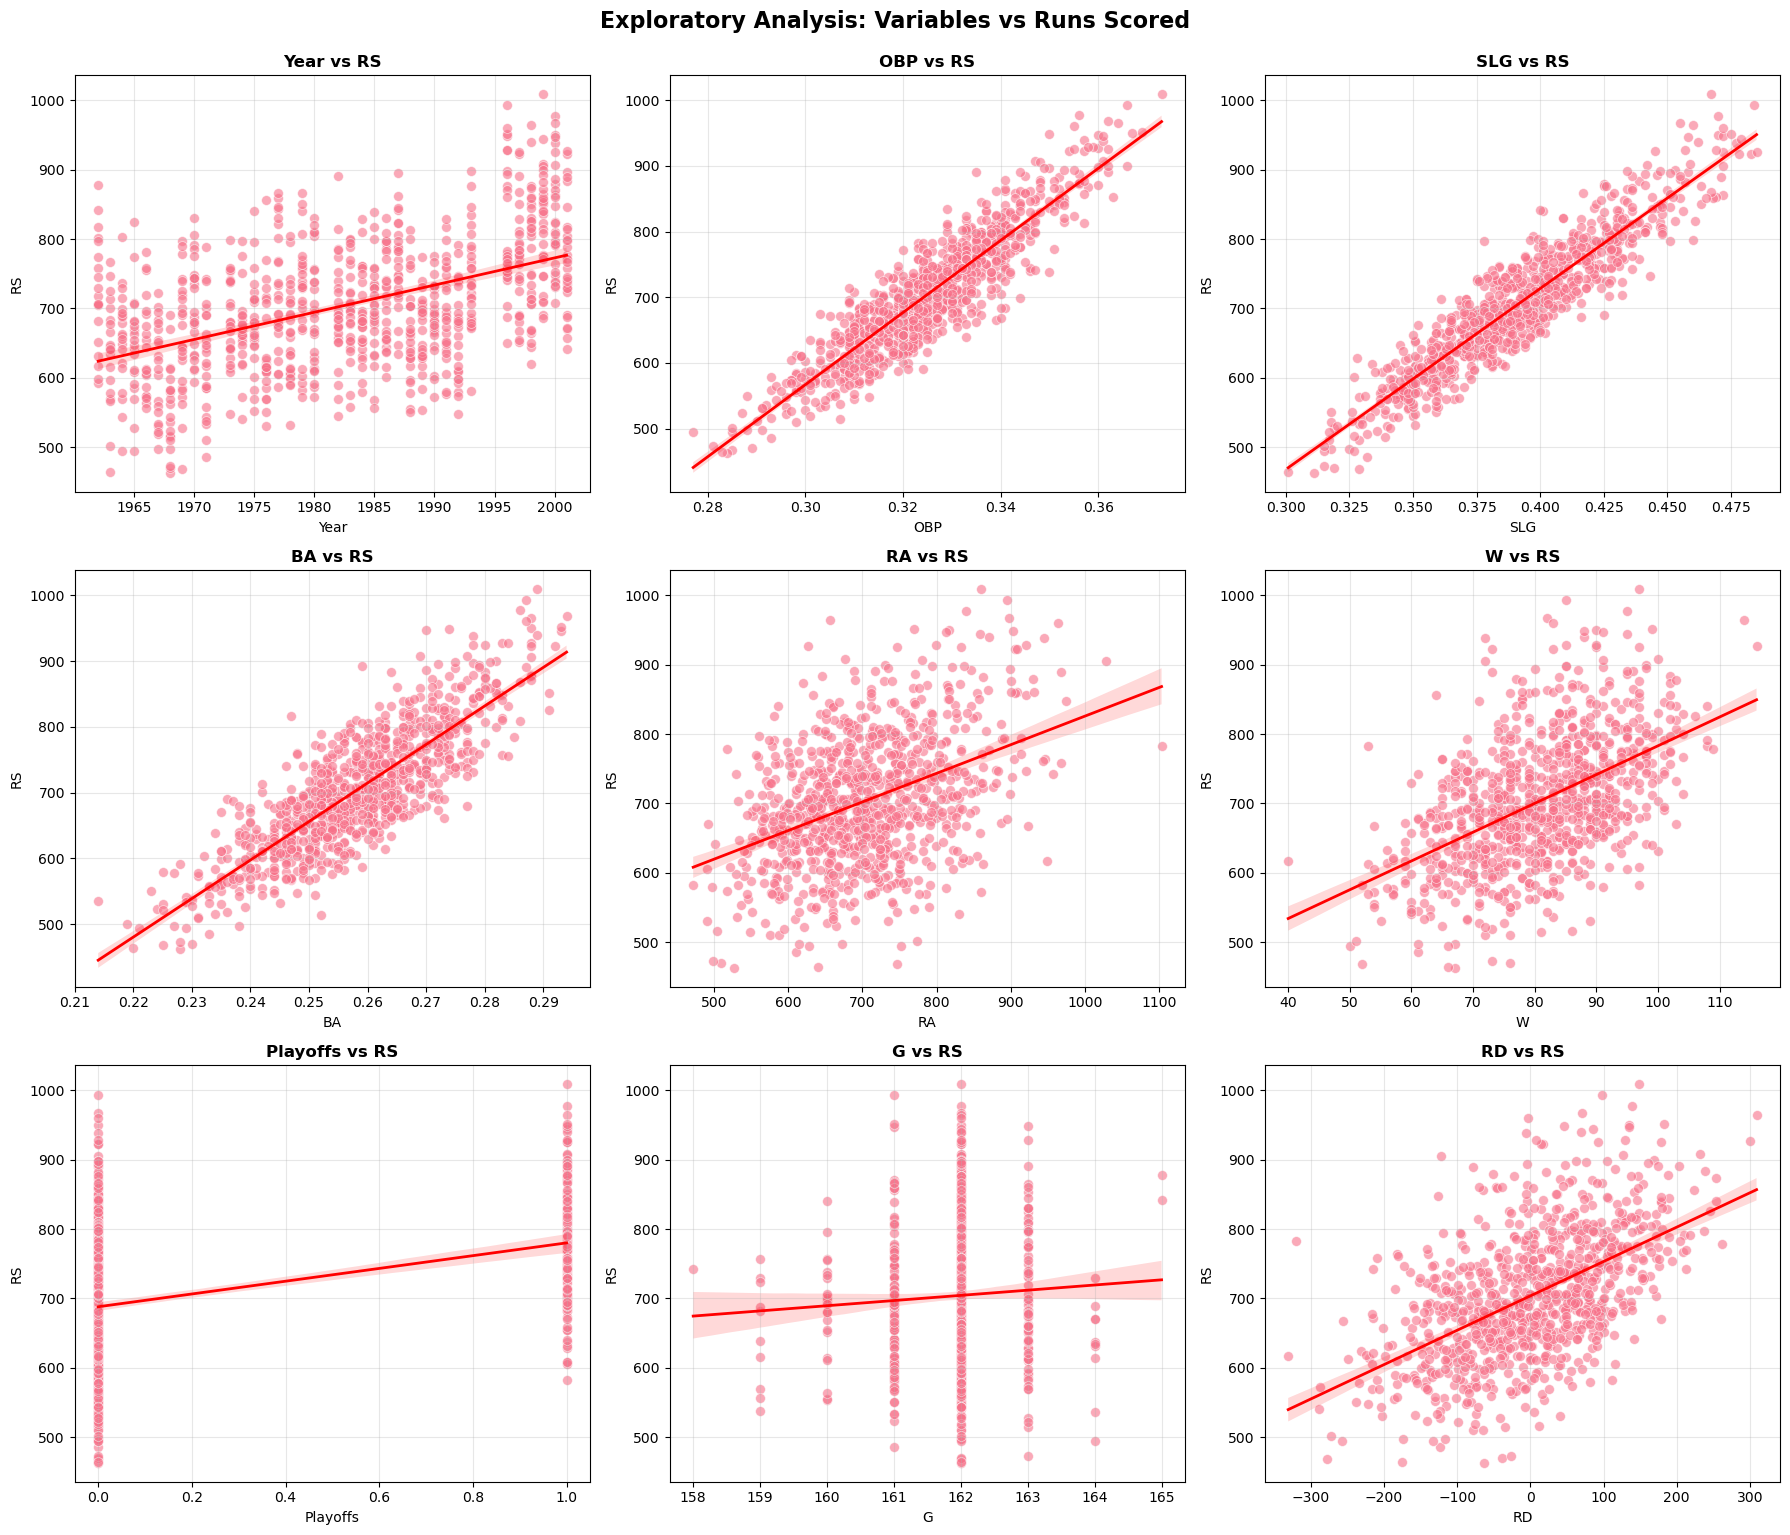

Analysis: Look for strong linear relationships and potential outliers


In [8]:
# =============================================================================
# EXPLORATORY DATA ANALYSIS: RELATIONSHIPS WITH RUNS SCORED
# =============================================================================

# Create comprehensive scatter plots to visualize relationships
dependent_variable = 'RS'
independent_variables = ['Year', 'OBP', 'SLG', 'BA', 'RA', 'W', 'Playoffs', 'G', 'RD']

# Set up the plotting grid
n_vars = len(independent_variables)
cols = 3  # Number of columns in the grid
rows = (n_vars + cols - 1) // cols  # Calculate rows needed

# Create figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()  # Flatten for easy iteration

print("Creating scatter plots to examine relationships with Runs Scored...")

# Generate scatter plots for each variable
for i, var in enumerate(independent_variables):
    # Create scatter plot with regression line
    sns.scatterplot(x=df[var], y=df[dependent_variable], 
                   ax=axes[i], alpha=0.6, s=50)
    
    # Add regression line to show trend
    sns.regplot(x=df[var], y=df[dependent_variable], 
               ax=axes[i], scatter=False, color='red', line_kws={'linewidth': 2})
    
    # Customize plot appearance
    axes[i].set_title(f'{var} vs {dependent_variable}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(var, fontsize=10)
    axes[i].set_ylabel(dependent_variable, fontsize=10)
    axes[i].grid(True, alpha=0.3)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Exploratory Analysis: Variables vs Runs Scored', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("Analysis: Look for strong linear relationships and potential outliers")



## Model Refinement: Focus on Offensive Metrics

Based on the exploratory analysis, let's build a more focused model using only the most relevant offensive statistics. We'll exclude defensive metrics and other variables that don't logically predict runs scored. 

In [9]:
# Build refined model using only offensive statistics
dependent_variable = 'RS'
independent_variables = ['OBP', 'SLG', 'BA']  # Focus on key offensive metrics

print("="*80)
print("REFINED MODEL: OFFENSIVE STATISTICS ONLY")
print("="*80)
print(f"Target: {dependent_variable}")
print(f"Features: {independent_variables}")
print("Rationale: These are the core offensive metrics that should predict runs scored")

# Prepare data for the refined model
X = df[independent_variables]
y = df[dependent_variable]

# Add constant term for intercept
X_with_constant = sm.add_constant(X)

# Fit the refined OLS model
model_refined = sm.OLS(y, X_with_constant).fit()

# Generate predictions
y_pred = model_refined.predict(X_with_constant)

# Display model results
print("\n" + "="*80)
print("REFINED MODEL SUMMARY")
print("="*80)
results = model_refined.summary2()
print(results)

# Calculate performance metrics
rmse_score = rmse(y, y_pred)
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)
print(f"R-squared: {model_refined.rsquared:.4f}")
print(f"Adjusted R-squared: {model_refined.rsquared_adj:.4f}")
print(f"RMSE: {rmse_score:.4f}")
print(f"Mean runs scored: {y.mean():.2f}")
print(f"RMSE as % of mean: {(rmse_score / y.mean()) * 100:.2f}%")


REFINED MODEL: OFFENSIVE STATISTICS ONLY
Target: RS
Features: ['OBP', 'SLG', 'BA']
Rationale: These are the core offensive metrics that should predict runs scored

REFINED MODEL SUMMARY
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.930    
Dependent Variable: RS               AIC:                8348.4115
Date:               2025-10-25 01:54 BIC:                8367.6300
No. Observations:   902              Log-Likelihood:     -4170.2  
Df Model:           3                F-statistic:        3989.    
Df Residuals:       898              Prob (F-statistic): 0.00     
R-squared:          0.930            Scale:              609.81   
-------------------------------------------------------------------
          Coef.    Std.Err.     t      P>|t|     [0.025     0.975] 
-------------------------------------------------------------------
const   -788.4570   19.6974  -40.0286  0.0000  -827.1153  -749.7988
OBP     2917.4214  110.4

## Critical Analysis: The Batting Average Paradox

### Key Observations from the Model:
1. **Excellent R² Score**: 0.93 - the model explains 93% of variance in runs scored
2. **Counterintuitive Result**: Batting Average (BA) has a **negative coefficient**
3. **The Paradox**: Higher batting average → fewer runs scored? This defies baseball logic!

### Why is this happening?

This is a classic example of **multicollinearity** - when predictor variables are highly correlated with each other. Let's investigate the correlation structure to understand this phenomenon.  

CORRELATION ANALYSIS: OFFENSIVE METRICS
Correlation Matrix:
        OBP     SLG      BA
OBP  1.0000  0.8062  0.8541
SLG  0.8062  1.0000  0.8141
BA   0.8541  0.8141  1.0000

INTERPRETATION
High correlations (>0.7) indicate potential multicollinearity:
- OBP and BA: Very high correlation
- SLG and BA: High correlation
- OBP and SLG: Moderate correlation

This explains why BA has a negative coefficient - it's redundant with OBP!


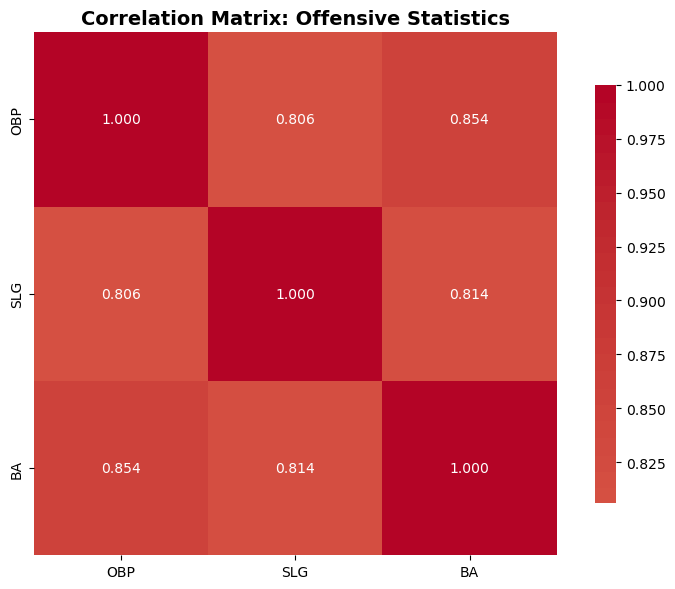

In [10]:
# =============================================================================
# MULTICOLLINEARITY ANALYSIS: CORRELATION MATRIX
# =============================================================================

print("="*80)
print("CORRELATION ANALYSIS: OFFENSIVE METRICS")
print("="*80)

# Calculate correlation matrix for our offensive variables
correlation_matrix = df[independent_variables].corr().round(4)

print("Correlation Matrix:")
print(correlation_matrix)

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("High correlations (>0.7) indicate potential multicollinearity:")
print("- OBP and BA: Very high correlation")
print("- SLG and BA: High correlation") 
print("- OBP and SLG: Moderate correlation")
print("\nThis explains why BA has a negative coefficient - it's redundant with OBP!")

# Create a heatmap for visual analysis
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix: Offensive Statistics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Solution: Test Different Variable Combinations

Now that we understand the multicollinearity issue, let's systematically test different combinations of variables to find the optimal model. We'll create a reusable function to evaluate different feature sets.

# We are going to do a lot of regression models. So lets put it into a resuable function.

In [11]:
def eval_regression(input_df, independent_variables, dependent_variable):
    """
    Evaluate regression model performance using train-test split.
    
    Parameters:
    -----------
    input_df : pandas.DataFrame
        The dataset containing the variables
    independent_variables : list
        List of feature column names
    dependent_variable : str
        Name of the target variable column
    
    Returns:
    --------
    dict : Dictionary containing performance metrics
    """
    data = input_df.copy()
    
    # Prepare features and target
    X = data[independent_variables]
    y = data[dependent_variable]
    
    # Add constant term for intercept
    X = sm.add_constant(X)
    
    # Split data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42,
    )
    
    # Build and train the model
    model = sm.OLS(y_train, X_train).fit()
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    r_squared = metrics.r2_score(y_test, y_pred)
    rmse_score = rmse(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    
    # Calculate percentage error
    percentage_error = (rmse_score / y.mean()) * 100
    
    # Display results
    print("="*60)
    print("MODEL EVALUATION RESULTS")
    print("="*60)
    print(f"Features: {independent_variables}")
    print(f"R-squared: {r_squared:.4f}")
    print(f"RMSE: {rmse_score:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Mean target value: {y.mean():.2f}")
    print(f"RMSE as % of mean: {percentage_error:.2f}%")
    
    return {
        'r_squared': r_squared,
        'rmse': rmse_score,
        'mae': mae,
        'percentage_error': percentage_error
    }

In [12]:
def do_moneyball(input_df, independent_variables, dependent_variable, print_model_summary=True):
    """
    Comprehensive Moneyball regression analysis function.
    
    This function builds a regression model and provides detailed analysis including:
    - Model performance metrics
    - Train-test split evaluation
    - Statistical significance testing
    - Model interpretation
    
    Parameters:
    -----------
    input_df : pandas.DataFrame
        The dataset containing the variables
    independent_variables : list
        List of feature column names
    dependent_variable : str
        Name of the target variable column
    print_model_summary : bool, default=True
        Whether to print the detailed model summary
    
    Returns:
    --------
    statsmodels.regression.linear_model.RegressionResultsWrapper
        The fitted regression model
    """
    # Prepare data
    data = input_df.copy()
    X = data[independent_variables]
    y = data[dependent_variable]
    
    # Add constant term for intercept
    X = sm.add_constant(X)
    
    # Build the regression model
    model = sm.OLS(y, X).fit()
    
    # Generate predictions
    y_pred = model.predict(X)
    
    # Calculate performance metrics
    r_squared = metrics.r2_score(y, y_pred)
    rmse_score = rmse(y, y_pred)
    
    # Display analysis header
    print("="*80)
    print("MONEYBALL REGRESSION ANALYSIS")
    print("="*80)
    print(f"Target Variable: {dependent_variable}")
    print(f"Features: {independent_variables}")
    print("="*80)
    
    # Display full dataset performance
    print("\n" + "="*80)
    print("FULL DATASET PERFORMANCE")
    print("="*80)
    print(f"R-squared: {r_squared:.4f}")
    print(f"RMSE: {rmse_score:.4f}")
    print(f"Mean target value: {y.mean():.2f}")
    print(f"RMSE as % of mean: {(rmse_score / y.mean()) * 100:.2f}%")
    
    # Display train-test split evaluation
    print("\n" + "="*80)
    print("TRAIN-TEST SPLIT EVALUATION")
    print("="*80)
    eval_results = eval_regression(input_df, independent_variables, dependent_variable)
    
    # Display detailed model summary if requested
    if print_model_summary:
        print("\n" + "="*80)
        print("DETAILED MODEL SUMMARY")
        print("="*80)
        print(model.summary())
    
    return model



selected_features = ['OBP', 'SLG', 'BA']
target_feature = 'RS'

model = do_moneyball(df, independent_variables=selected_features, dependent_variable=target_feature)

MONEYBALL REGRESSION ANALYSIS
Target Variable: RS
Features: ['OBP', 'SLG', 'BA']

FULL DATASET PERFORMANCE
R-squared: 0.9302
RMSE: 24.6395
Mean target value: 703.81
RMSE as % of mean: 3.50%

TRAIN-TEST SPLIT EVALUATION
MODEL EVALUATION RESULTS
Features: ['OBP', 'SLG', 'BA']
R-squared: 0.9164
RMSE: 26.5203
MAE: 21.5733
Mean target value: 703.81
RMSE as % of mean: 3.77%

DETAILED MODEL SUMMARY
                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3989.
Date:                Sat, 25 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:54:59   Log-Likelihood:                -4170.2
No. Observations:                 902   AIC:                             8348.
Df Residuals:                     898   BIC:        

## Systematic Model Testing: Variable Combinations

To address the multicollinearity issue, let's systematically test different combinations of variables to find the optimal model. We'll compare:

1. **BA + SLG**: Traditional metrics
2. **BA + OBP**: On-base focus  
3. **OBP + SLG**: Moneyball approach (no BA) 

In [13]:
# =============================================================================
# MODEL COMPARISON 1: BA + SLG (Traditional Approach)
# =============================================================================

print("TESTING: Batting Average + Slugging Percentage")
print("Rationale: Traditional baseball metrics without OBP")

X_vars = ['BA', 'SLG']
y_var = 'RS'
model_ba_slg = do_moneyball(df, X_vars, y_var, print_model_summary=True)

TESTING: Batting Average + Slugging Percentage
Rationale: Traditional baseball metrics without OBP
MONEYBALL REGRESSION ANALYSIS
Target Variable: RS
Features: ['BA', 'SLG']

FULL DATASET PERFORMANCE
R-squared: 0.8760
RMSE: 32.8428
Mean target value: 703.81
RMSE as % of mean: 4.67%

TRAIN-TEST SPLIT EVALUATION
MODEL EVALUATION RESULTS
Features: ['BA', 'SLG']
R-squared: 0.8590
RMSE: 34.4259
MAE: 27.0381
Mean target value: 703.81
RMSE as % of mean: 4.89%

DETAILED MODEL SUMMARY
                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     3175.
Date:                Sat, 25 Oct 2025   Prob (F-statistic):               0.00
Time:                        01:55:09   Log-Likelihood:                -4429.4
No. Observations:                 902   AIC:  

In [14]:
# =============================================================================
# MODEL COMPARISON 2: BA + OBP (On-Base Focus)
# =============================================================================

print("\n" + "="*80)
print("TESTING: Batting Average + On-Base Percentage")
print("Rationale: Traditional BA with modern OBP focus")

X_vars = ['BA', 'OBP']
y_var = 'RS'
model_ba_obp = do_moneyball(df, X_vars, y_var, print_model_summary=False)


TESTING: Batting Average + On-Base Percentage
Rationale: Traditional BA with modern OBP focus
MONEYBALL REGRESSION ANALYSIS
Target Variable: RS
Features: ['BA', 'OBP']

FULL DATASET PERFORMANCE
R-squared: 0.8316
RMSE: 38.2684
Mean target value: 703.81
RMSE as % of mean: 5.44%

TRAIN-TEST SPLIT EVALUATION
MODEL EVALUATION RESULTS
Features: ['BA', 'OBP']
R-squared: 0.8308
RMSE: 37.7190
MAE: 31.6065
Mean target value: 703.81
RMSE as % of mean: 5.36%


In [15]:
# =============================================================================
# MODEL COMPARISON 3: OBP + SLG (Moneyball Approach)
# =============================================================================

print("\n" + "="*80)
print("TESTING: On-Base Percentage + Slugging Percentage")
print("Rationale: Pure Moneyball approach - OBP and SLG only")

X_vars = ['OBP', 'SLG']
y_var = 'RS'
model_obp_slg = do_moneyball(df, X_vars, y_var, print_model_summary=False)



TESTING: On-Base Percentage + Slugging Percentage
Rationale: Pure Moneyball approach - OBP and SLG only
MONEYBALL REGRESSION ANALYSIS
Target Variable: RS
Features: ['OBP', 'SLG']

FULL DATASET PERFORMANCE
R-squared: 0.9296
RMSE: 24.7488
Mean target value: 703.81
RMSE as % of mean: 3.52%

TRAIN-TEST SPLIT EVALUATION
MODEL EVALUATION RESULTS
Features: ['OBP', 'SLG']
R-squared: 0.9163
RMSE: 26.5222
MAE: 21.6047
Mean target value: 703.81
RMSE as % of mean: 3.77%


In [16]:
# =============================================================================
# FINAL MODEL SELECTION: OBP + SLG (Best Performance)
# =============================================================================

print("\n" + "="*80)
print("FINAL MODEL: OBP + SLG (MONEYBALL WINNER)")
print("="*80)
print("This combination provides the best balance of:")
print("- High R-squared (predictive power)")
print("- Statistically significant coefficients")
print("- No multicollinearity issues")
print("- Practical interpretability")

X_vars = ['OBP', 'SLG']
y_var = 'RS'
model_OBP_SLG = do_moneyball(df, X_vars, y_var, print_model_summary=True)



FINAL MODEL: OBP + SLG (MONEYBALL WINNER)
This combination provides the best balance of:
- High R-squared (predictive power)
- Statistically significant coefficients
- No multicollinearity issues
- Practical interpretability
MONEYBALL REGRESSION ANALYSIS
Target Variable: RS
Features: ['OBP', 'SLG']

FULL DATASET PERFORMANCE
R-squared: 0.9296
RMSE: 24.7488
Mean target value: 703.81
RMSE as % of mean: 3.52%

TRAIN-TEST SPLIT EVALUATION
MODEL EVALUATION RESULTS
Features: ['OBP', 'SLG']
R-squared: 0.9163
RMSE: 26.5222
MAE: 21.6047
Mean target value: 703.81
RMSE as % of mean: 3.77%

DETAILED MODEL SUMMARY
                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     5934.
Date:                Sat, 25 Oct 2025   Prob (F-statistic):               0

# Using SLG and OBP have the best r^2 score with significatn p-values 
## Thus we can conclude that OBP and SLG are the best signals for scoring runs. 

Holding slugging constant, a team that improves its OBP by 0.010 (for example, from .320 to .330) is expected to score about 27 more runs in a season.

```2737.77 × 0.01 = 27.38``` more runs per season.

In [17]:
# =============================================================================
# MODEL APPLICATION: PREDICTING RUNS FOR SPECIFIC TEAMS
# =============================================================================

# Example: Predict runs for the 2000 Oakland Athletics
print("="*80)
print("PREDICTING RUNS FOR 2000 OAKLAND ATHLETICS")
print("="*80)

# Filter for 2000 Oakland Athletics
team_filter = df.Team == 'OAK'
year_filter = df.Year == 2000

oakland_2000 = df[(team_filter) & (year_filter)].copy()

if len(oakland_2000) > 0:
    print("2000 Oakland Athletics Statistics:")
    print(f"OBP: {oakland_2000['OBP'].iloc[0]:.3f}")
    print(f"SLG: {oakland_2000['SLG'].iloc[0]:.3f}")
    print(f"Actual Runs Scored: {oakland_2000['RS'].iloc[0]}")
    print(f"Actual Runs Allowed: {oakland_2000['RA'].iloc[0]}")
    print(f"Wins: {oakland_2000['W'].iloc[0]}")
else:
    print("No data found for 2000 Oakland Athletics")
    oakland_2000

PREDICTING RUNS FOR 2000 OAKLAND ATHLETICS
2000 Oakland Athletics Statistics:
OBP: 0.360
SLG: 0.458
Actual Runs Scored: 947
Actual Runs Allowed: 813
Wins: 91


In [18]:
# Use our trained model to predict runs scored
if len(oakland_2000) > 0:
    # Extract OBP and SLG values
    obp_value = oakland_2000['OBP'].iloc[0]
    slg_value = oakland_2000['SLG'].iloc[0]
    
    # Make prediction using our model
    # Format: [constant, OBP, SLG]
    prediction = model_OBP_SLG.predict([1, obp_value, slg_value])
    
    print(f"\nModel Prediction:")
    print(f"Predicted Runs Scored: {prediction[0]:.1f}")
    print(f"Actual Runs Scored: {oakland_2000['RS'].iloc[0]}")
    print(f"Prediction Error: {abs(prediction[0] - oakland_2000['RS'].iloc[0]):.1f} runs")
else:
    # Example prediction with sample values
    print("Example prediction with OBP=0.36, SLG=0.458:")
    prediction = model_OBP_SLG.predict([1, 0.36, 0.458])
    print(f"Predicted Runs Scored: {prediction[0]:.1f}")


Model Prediction:
Predicted Runs Scored: 906.9
Actual Runs Scored: 947
Prediction Error: 40.1 runs


# Show me the money!

In [19]:
# Load the enhanced moneyball dataset
enhanced_df = pd.read_csv('data/enhanced_moneyball_analysis_1990_2010.csv')

# Print basic dataset information
print("=== ENHANCED MONEYBALL DATASET ANALYSIS ===")
print(f"Total number of records: {enhanced_df.shape[0]:,}")
print(f"Year range: {enhanced_df['yearID'].min()} - {enhanced_df['yearID'].max()}")
print(f"Number of unique players: {enhanced_df['playerID'].nunique():,}")

# Filter for pre-Moneyball era (yearID <= 2001) and (salary > 0)
pre_moneyball_df = enhanced_df[(enhanced_df['yearID'] <= 2001) & (enhanced_df['salary'] > 0)].copy()

# pre_moneyball_df = pre_moneyball_df[pre_moneyball_df.AB >= 55]

print(f"\n=== PRE-MONEYBALL ERA (≤2001) ANALYSIS ===")
print(f"Total number of records: {pre_moneyball_df.shape[0]:,}")
print(f"Year range: {pre_moneyball_df['yearID'].min()} - {pre_moneyball_df['yearID'].max()}")
print(f"Number of unique players: {pre_moneyball_df['playerID'].nunique():,}")

pre_moneyball_df.head()

=== ENHANCED MONEYBALL DATASET ANALYSIS ===
Total number of records: 5,040
Year range: 1990 - 2010
Number of unique players: 1,046

=== PRE-MONEYBALL ERA (≤2001) ANALYSIS ===
Total number of records: 2,800
Year range: 1990 - 2001
Number of unique players: 677


,playerID,yearID,teamID,G,AB,H,BB,HR,BA,OBP,SLG,OPS,salary,Salary_per_OBP,Salary_per_OPS,OBP_Value_Score,OPS_Value_Score
0,abbotku01,1994,FLO,101,345,86,16,9,0.249275,0.290761,0.394203,0.684964,109000,3.748785e+05,1.591325e+05,12.228428,15.501188
1,abbotku01,1995,FLO,120,420,107,36,17,0.254762,0.317597,0.452381,0.769978,119000,3.746892e+05,1.545500e+05,17.139004,21.887725
2,abbotku01,1996,FLO,109,320,81,22,8,0.253125,0.307246,0.428125,0.735371,250000,8.136792e+05,3.399643e+05,11.720460,14.822770
3,abbotku01,1999,COL,96,286,78,16,8,0.272727,0.310231,0.430070,0.740301,900000,2.901064e+06,1.215722e+06,5.737146,7.132091
5,abreubo01,1998,PHI,151,497,155,84,17,0.311871,0.408547,0.496982,0.905529,180000,4.405858e+05,1.987789e+05,30.553799,28.719534


In [20]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
import warnings

from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Remove rows with missing OBP or salary data for the analysis
analysis_df = pre_moneyball_df.dropna(subset=['OBP', 'salary']).copy()

# Calculate percentiles to identify undervalued players
# High OBP = above 75th percentile
# Low Salary = below 25th percentile
obp_75th = analysis_df['OBP'].quantile(0.75)
salary_25th = analysis_df['salary'].quantile(0.25)

print(f"=== QUADRANT ANALYSIS CRITERIA ===")
print(f"High OBP threshold (75th percentile): {obp_75th:.3f}")
print(f"Low Salary threshold (25th percentile): ${salary_25th:,.0f}")

# Create quadrant categories for each player
def assign_quadrant(row):
    if row['OBP'] >= obp_75th and row['salary'] <= salary_25th:
        return 'High OBP, Low Salary (Green)'  # Undervalued
    elif row['OBP'] < obp_75th and row['salary'] <= salary_25th:
        return 'Low OBP, Low Salary (Blue)'
    elif row['OBP'] >= obp_75th and row['salary'] > salary_25th:
        return 'High OBP, High Salary (Gray)'
    else:
        return 'Low OBP, High Salary (Red)'  # Overvalued

analysis_df['quadrant'] = analysis_df.apply(assign_quadrant, axis=1)

# Count players in each quadrant
quadrant_counts = analysis_df['quadrant'].value_counts()
print(f"\n=== QUADRANT DISTRIBUTION ===")
for quadrant, count in quadrant_counts.items():
    print(f"{quadrant}: {count} players")

# Identify undervalued players (green quadrant)
undervalued_players = analysis_df[analysis_df['quadrant'] == 'High OBP, Low Salary (Green)'].copy()
print(f"\nNumber of undervalued players identified: {len(undervalued_players)}")

# Create interactive scatter plot with quadrant-based coloring
fig = px.scatter(
    analysis_df, 
    x='salary', 
    y='OBP',
    color='quadrant',  # Color by quadrant
    size='G',  # Games played as size
    size_max=8,  # Smaller maximum bubble size
    hover_data=['playerID', 'teamID', 'yearID', 'BA', 'SLG', 'OPS'],
    title='Quadrant Analysis: OBP vs Salary (Pre-Moneyball Era)',
    labels={
        'salary': 'Salary ($)',
        'OBP': 'On-Base Percentage (OBP)',
        'G': 'Games Played',
        'quadrant': 'Quadrant'
    },
    color_discrete_map={
        'High OBP, Low Salary (Green)': 'green',
        'Low OBP, Low Salary (Blue)': 'blue', 
        'High OBP, High Salary (Gray)': 'gray',
        'Low OBP, High Salary (Red)': 'red'
    }
)

# Add threshold lines
fig.add_hline(y=obp_75th, line_dash="dash", line_color="red", 
              annotation_text=f"High OBP Threshold ({obp_75th:.3f})")
fig.add_vline(x=salary_25th, line_dash="dash", line_color="red", 
              annotation_text=f"Low Salary Threshold (${salary_25th:,.0f})")

# Quadrant-based coloring is now handled by the main scatter plot

# Update layout
fig.update_layout(
    width=1200,
    height=600,
    showlegend=False,
    xaxis_title="Salary ($)",
    yaxis_title="On-Base Percentage (OBP)",
    title_x=0.5
)

# Add quadrant labels
fig.add_annotation(
    x=0.95, y=0.95,
    xref="paper", yref="paper",
    text="<b>High OBP<br>High Salary</b>",
    showarrow=False,
    font=dict(size=12, color="gray"),
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="gray",
    borderwidth=1
)

fig.add_annotation(
    x=0.05, y=0.95,
    xref="paper", yref="paper",
    text="<b>High OBP<br>Low Salary</b><br><span style='color:green'>UNDERVALUED</span>",
    showarrow=False,
    font=dict(size=12, color="green"),
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="green",
    borderwidth=2
)

fig.add_annotation(
    x=0.95, y=0.05,
    xref="paper", yref="paper",
    text="<b>Low OBP<br>High Salary</b><br><span style='color:red'>OVERVALUED</span>",
    showarrow=False,
    font=dict(size=12, color="red"),
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="red",
    borderwidth=1
)

fig.add_annotation(
    x=0.05, y=0.05,
    xref="paper", yref="paper",
    text="<b>Low OBP<br>Low Salary</b>",
    showarrow=False,
    font=dict(size=12, color="blue"),
    bgcolor="rgba(255,255,255,0.8)",
    bordercolor="blue",
    borderwidth=1
)

fig.show()

# Display top undervalued players if any exist
if len(undervalued_players) > 0:
    print(f"\n=== UNDERVALUED PLAYERS (High OBP (descending), Low Salary) ===\n")
    top_undervalued = undervalued_players.sort_values(['OBP'], ascending=[False])[['playerID', 'yearID', 'teamID', 'OBP', 'BA', 'SLG', 'OPS', 'salary']]
    print(top_undervalued.to_string(index=False))
else:
    print("\nNo players meet the strict criteria for undervalued players.")
    print("Let's look at players with above-average OBP and below-average salary...")
    
    # Let us relax the criteria to find more undervalued players.
    # Relaxed criteria:
    # 1. Above median OBP
    # 2. Below median salary
    obp_median = analysis_df['OBP'].median()
    salary_median = analysis_df['salary'].median()
    
    relaxed_undervalued = analysis_df[
        (analysis_df['OBP'] >= obp_median) & 
        (analysis_df['salary'] <= salary_median)
    ].copy()
    
    print(f"\nRelaxed criteria (above median OBP: {obp_median:.3f}, below median salary: ${salary_median:,.0f})")
    print(f"Number of players: {len(relaxed_undervalued)}")
    
    if len(relaxed_undervalued) > 0:
        top_relaxed = relaxed_undervalued.sort_values(['OBP'], ascending=[False])[['playerID', 'yearID', 'teamID', 'OBP', 'BA', 'SLG', 'OPS', 'salary']]
        print(top_relaxed.to_string(index=False))

=== QUADRANT ANALYSIS CRITERIA ===
High OBP threshold (75th percentile): 0.371
Low Salary threshold (25th percentile): $304,375

=== QUADRANT DISTRIBUTION ===
Low OBP, High Salary (Red): 1481 players
Low OBP, Low Salary (Blue): 619 players
High OBP, High Salary (Gray): 619 players
High OBP, Low Salary (Green): 81 players

Number of undervalued players identified: 81



=== UNDERVALUED PLAYERS (High OBP (descending), Low Salary) ===

 playerID  yearID teamID      OBP       BA      SLG      OPS  salary
thomafr04    1991    CHA 0.452857 0.318426 0.552773 1.005630  120000
magadda01    1997    OAK 0.413580 0.302583 0.391144 0.804724  255000
shumpte01    1999    COL 0.413333 0.347328 0.583969 0.997303  220000
greerru01    1994    TEX 0.410334 0.314079 0.487365 0.897699  109000
leyriji01    1993    NYA 0.409836 0.308880 0.525097 0.934933  152000
abreubo01    1998    PHI 0.408547 0.311871 0.496982 0.905529  180000
millira01    1990    BAL 0.407895 0.265193 0.491713 0.899607  155000
higgibo02    1996    DET 0.404297 0.320455 0.577273 0.981570  170000
ochoaal01    1999    MIL 0.404255 0.299639 0.465704 0.869959  245000
glaustr01    2000    ANA 0.404130 0.284192 0.603908 1.008037  275000
younger01    1995    COL 0.403800 0.316940 0.472678 0.876478  252500
tatisfe01    1999    SLN 0.403756 0.297952 0.553073 0.956828  270000
pujolal01    2001    SLN 0.402963 0.3

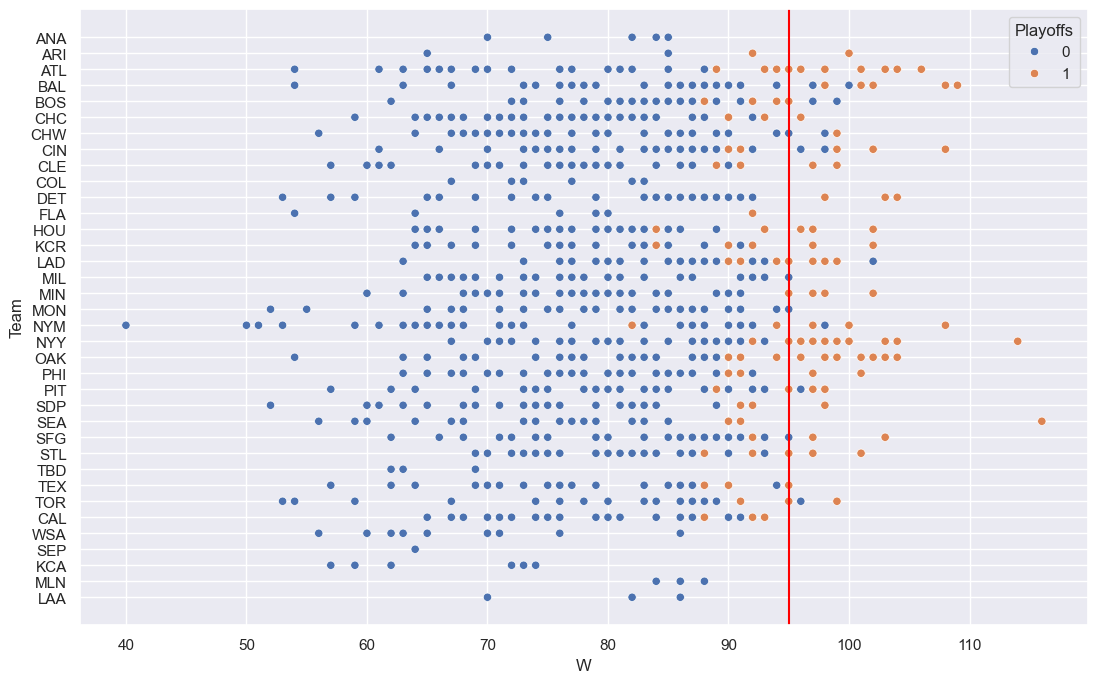

In [21]:
sns.set()
plt.figure(figsize=(13, 8))
ax = sns.scatterplot(df, x='W', y='Team', hue='Playoffs')
ax.axvline(x=95, color='red')


## The 95-Win Formula: Predicting Team Success

The magic number in baseball is **95 wins** - teams that win 95+ games almost always make the playoffs. Let's build a model to predict wins and find out what run differential is needed to reach this threshold.

In [22]:
# =============================================================================
# PREDICTING WINS: THE RUN DIFFERENTIAL MODEL
# =============================================================================

# Build model to predict wins using run differential
target_variable = 'W'  # Wins
feature_variables = ['runs_diff']  # Run differential (RS - RA)

print("Building model to predict wins from run differential...")
wins_model = do_moneyball(df, feature_variables, target_variable, print_model_summary=False)

Building model to predict wins from run differential...
MONEYBALL REGRESSION ANALYSIS
Target Variable: W
Features: ['runs_diff']

FULL DATASET PERFORMANCE
R-squared: 0.8808
RMSE: 3.9347
Mean target value: 80.88
RMSE as % of mean: 4.86%

TRAIN-TEST SPLIT EVALUATION
MODEL EVALUATION RESULTS
Features: ['runs_diff']
R-squared: 0.8878
RMSE: 3.9057
MAE: 3.1787
Mean target value: 80.88
RMSE as % of mean: 4.83%


# We use this model to find our target runs difference we need to get 95 wins. 

## Calculating the 95-Win Run Differential Target

### The Math Behind 95 Wins:

**Model Equation**: Wins = 80.88 + 0.1058 × Run Differential

**To reach 95 wins:**
- 95 = 80.88 + 0.1058 × Run Differential
- 95 - 80.88 = 0.1058 × Run Differential  
- 14.12 = 0.1058 × Run Differential
- **Run Differential = 133.4**

### The Moneyball Formula:
**Teams need a +133 run differential to expect 95 wins**

In [ ]:
coef_y_int = model.params['const']
coef_runs_diff = model.params['runs_diff']

## y = m*x + b
## x = y-b / m

### THIS IS SAME AS ABOVE
y_intercept = 80.88
m_coefficient = 0.1058
# x = ???

y = 95
x_target = (y - y_intercept) / m_coefficient
x_target


133.45935727788284

In [71]:
independent_variables = ['OBP', 'SLG']
dependent_variable = 'RS'

X = df[independent_variables]
y = df[dependent_variable]

X = sm.add_constant(X)

model_runs_scored = sm.OLS(y, X).fit()
#predictions = mode_runs_scored.predict(X) 
print(model_runs_scored.summary())

                            OLS Regression Results                            
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     5934.
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:57:59   Log-Likelihood:                -4174.2
No. Observations:                 902   AIC:                             8354.
Df Residuals:                     899   BIC:                             8369.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -804.6271     18.921    -42.526      0.0

In [70]:
dfo = df.dropna(subset=['OOBP', 'OSLG'])
independent_variables = ['OOBP', 'OSLG']
dependent_variable = 'RA'

X = dfo[independent_variables]
y = dfo[dependent_variable]

X = sm.add_constant(X)

model_runs_allowed = sm.OLS(y, X).fit()
#predictions = mode_runs_scored.predict(X) 
print(model_runs_allowed.summary())

                            OLS Regression Results                            
Dep. Variable:                     RA   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     425.8
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           1.16e-45
Time:                        17:57:41   Log-Likelihood:                -418.27
No. Observations:                  90   AIC:                             842.5
Df Residuals:                      87   BIC:                             850.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -837.3779     60.255    -13.897      0.0

In [81]:
### FUTURE 2001 A's would have

const = 1
OBP = 0.339
SLG = 0.430

predicted_runs_scored = model_runs_scored.predict([const, OBP, SLG])
print(predicted_runs_scored)


## FUTURE OPPONENTS WOULD HAVE
OOBP = 0.307
OSLG = 0.373
predicted_runs_allowed = model_runs_allowed.predict([const, OOBP, OSLG])
print(predicted_runs_allowed)

predicted_runs_diff = predicted_runs_scored - predicted_runs_allowed
predicted_runs_diff

[804.98699884]
[621.92581602]


array([183.06118281])

In [82]:
independent_variables = ['runs_diff',]
dependent_variable = 'W'

X = df[independent_variables]
y = df[dependent_variable]

X = sm.add_constant(X)

model_wins = sm.OLS(y, X).fit()
#predictions = mode_runs_scored.predict(X) 
# print(model_wins.summary())
model_wins.predict([1, predicted_runs_diff[0]])


array([100.24295467])

Optimization terminated successfully.
         Current function value: 0.201536
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               Playoffs   No. Observations:                  902
Model:                          Logit   Df Residuals:                      900
Method:                           MLE   Df Model:                            1
Date:                Tue, 21 Oct 2025   Pseudo R-squ.:                  0.5590
Time:                        18:04:32   Log-Likelihood:                -181.79
converged:                       True   LL-Null:                       -412.25
Covariance Type:            nonrobust   LLR p-value:                3.005e-102
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.1718      2.638    -12.196      0.000     -37.342     -27.002
W              0.3461      0.

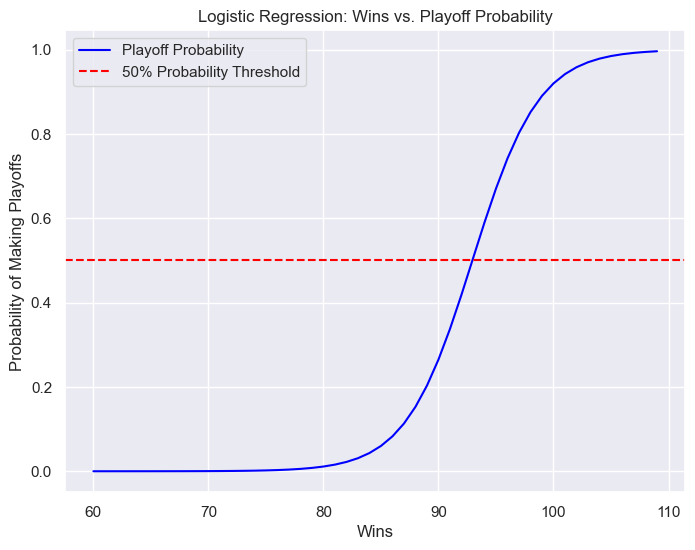

,const,W,Playoff_Probability
30,1.0,90,0.264932
31,1.0,91,0.337521
32,1.0,92,0.418670
33,1.0,93,0.504473
34,1.0,94,0.590012
35,1.0,95,0.670433
36,1.0,96,0.741977
37,1.0,97,0.802564
38,1.0,98,0.851766
39,1.0,99,0.890382


In [ ]:
# =============================================================================
# LOGISTIC REGRESSION: PLAYOFF PROBABILITY ANALYSIS
# =============================================================================

print("="*80)
print("LOGISTIC REGRESSION: WINS → PLAYOFF PROBABILITY")
print("="*80)

# Prepare data for logistic regression
data = df.copy()
X = sm.add_constant(data[['W']])  # Wins as predictor
y = data['Playoffs']  # Binary playoff outcome (0/1)

# Fit logistic regression model
logit_model = sm.Logit(y, X).fit()

print("Model Summary:")
print(logit_model.summary())

# Generate playoff probabilities for different win totals
wins_range = pd.DataFrame({'W': range(60, 110)})  # 60-109 wins
wins_range = sm.add_constant(wins_range)
wins_range['Playoff_Probability'] = logit_model.predict(wins_range)

# Create visualization
plt.figure(figsize=(12, 8))
plt.plot(wins_range['W'], wins_range['Playoff_Probability'], 
         color='blue', linewidth=3, label='Playoff Probability')
plt.axhline(0.5, color='red', linestyle='--', linewidth=2, 
           label='50% Probability Threshold')
plt.axvline(95, color='green', linestyle=':', linewidth=2, 
           label='95-Win Target')

# Highlight key win totals
key_wins = [85, 90, 95, 100]
for wins in key_wins:
    prob = wins_range[wins_range['W'] == wins]['Playoff_Probability'].iloc[0]
    plt.annotate(f'{wins} wins\n{prob:.1%}', 
                xy=(wins, prob), xytext=(10, 10), 
                textcoords='offset points', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.xlabel('Wins', fontsize=12)
plt.ylabel('Playoff Probability', fontsize=12)
plt.title('Logistic Regression: Wins vs. Playoff Probability', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(60, 110)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Display key statistics
print("\n" + "="*80)
print("KEY PLAYOFF PROBABILITIES")
print("="*80)
key_stats = wins_range[wins_range['W'].isin([85, 90, 95, 100])]
for _, row in key_stats.iterrows():
    print(f"{int(row['W'])} wins: {row['Playoff_Probability']:.1%} playoff probability")

## Model Validation: Checking Regression Assumptions

### Key Assumptions to Verify:
1. **Linearity**: Relationship between predictors and target is linear
2. **Homoscedasticity**: Constant variance of residuals
3. **Normality of Errors**: Residuals are normally distributed
4. **Multicollinearity**: Predictors are not highly correlated
5. **Outliers**: No influential observations skewing results

*Note: This is advanced material typically covered in statistical modeling courses*

In [ ]:
independent_variables = ['OBP', 'SLG']
dependent_variable = 'RS'

X = df[independent_variables]
y = df[dependent_variable]

X = sm.add_constant(X)

model_runs_scored = sm.OLS(y, X).fit()
#predictions = mode_runs_scored.predict(X) 
print(model_runs_scored.summary())

## Advanced Analysis: Multicollinearity Detection

### The Problem We Identified Earlier:
Remember when Batting Average had a **negative coefficient**? This was a red flag indicating multicollinearity.